In [72]:
# set_determinism : monai에서 제공하는 seed값 고정 util.
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    MapLabelValued,
    ConcatItemsd,
    Lambdad,
    ScaleIntensityd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

In [21]:
root_dir = '/data/train/running/l/input_augmented'


train_images = sorted(
    glob.glob(os.path.join(root_dir, "*_T1.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(root_dir, "*_l.nii.gz")))
train_brains = sorted(
    glob.glob(os.path.join(root_dir, "*_b.nii.gz")))
train_masks = sorted(
    glob.glob(os.path.join(root_dir, "*_m.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name, "brain": brain_name, "mask": mask_name}
    for image_name, label_name, brain_name, mask_name in zip(train_images, train_labels, train_brains, train_masks)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [22]:
train_files

[{'image': '/data/train/running/l/input_augmented/s_14040501_00_0_T1.nii.gz',
  'label': '/data/train/running/l/input_augmented/s_14040501_00_0_l.nii.gz',
  'brain': '/data/train/running/l/input_augmented/s_14040501_00_0_b.nii.gz',
  'mask': '/data/train/running/l/input_augmented/s_14040501_00_0_m.nii.gz'},
 {'image': '/data/train/running/l/input_augmented/s_14040501_01_d_T1.nii.gz',
  'label': '/data/train/running/l/input_augmented/s_14040501_01_d_l.nii.gz',
  'brain': '/data/train/running/l/input_augmented/s_14040501_01_d_b.nii.gz',
  'mask': '/data/train/running/l/input_augmented/s_14040501_01_d_m.nii.gz'},
 {'image': '/data/train/running/l/input_augmented/s_14040501_02_d_T1.nii.gz',
  'label': '/data/train/running/l/input_augmented/s_14040501_02_d_l.nii.gz',
  'brain': '/data/train/running/l/input_augmented/s_14040501_02_d_b.nii.gz',
  'mask': '/data/train/running/l/input_augmented/s_14040501_02_d_m.nii.gz'},
 {'image': '/data/train/running/l/input_augmented/s_14040501_03_d_T1.nii.

In [23]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label", "brain", "mask"]),
        EnsureChannelFirstd(keys=["image", "label", "brain", "mask"]),
#         Spacingd(keys=["image", "label"], pixdim=(
#             1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label", "brain", "mask"], axcodes="RAS"),
#         Orientationd(keys=["image"], axcodes="LPS"),
#         ScaleIntensityRanged(
#             keys=["image"], a_min=-57, a_max=164,
#             b_min=0.0, b_max=1.0, clip=True,
#         ),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
#         EnsureTyped(keys=["image", "label"]),
    ]
)

torch.Size([1, 1, 186, 230, 230]) torch.Size([1, 1, 186, 230, 230])
torch.Size([1, 1, 186, 230, 230]) torch.Size([1, 1, 186, 230, 230])
image shape: torch.Size([186, 230, 230]), label shape: torch.Size([186, 230, 230])


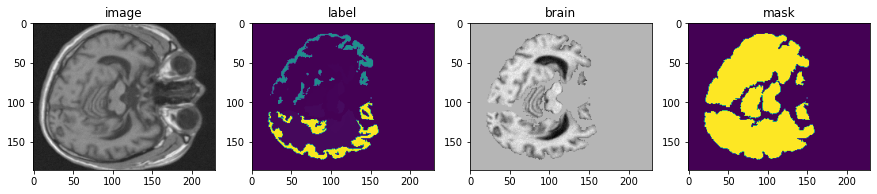

In [24]:
H=100

check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
brain, mask = (check_data["brain"][0][0], check_data["mask"][0][0])
print(check_data['image'].shape, check_data['label'].shape)
print(check_data['brain'].shape, check_data['mask'].shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (15, 10))
plt.subplot(1, 4, 1)
plt.title("image")
plt.imshow(image[:, :, H], cmap="gray")
plt.subplot(1, 4, 2)
plt.title("label")
plt.imshow(label[:, :, H])
plt.subplot(1, 4, 3)
plt.title("brain")
plt.imshow(brain[:, :, H], cmap="gray")
plt.subplot(1, 4, 4)
plt.title("mask")
plt.imshow(mask[:, :, H])
plt.show()

In [25]:
check_data.keys()

dict_keys(['image', 'label', 'brain', 'mask', 'image_meta_dict', 'label_meta_dict', 'brain_meta_dict', 'mask_meta_dict', 'image_transforms', 'label_transforms', 'brain_transforms', 'mask_transforms'])

In [26]:
check_data['image_meta_dict']

{'sizeof_hdr': tensor([348], dtype=torch.int32),
 'extents': tensor([0], dtype=torch.int32),
 'session_error': tensor([0], dtype=torch.int16),
 'dim_info': tensor([0], dtype=torch.uint8),
 'dim': tensor([[  3, 186, 230, 230,   1,   1,   1,   1]], dtype=torch.int16),
 'intent_p1': tensor([0.]),
 'intent_p2': tensor([0.]),
 'intent_p3': tensor([0.]),
 'intent_code': tensor([0], dtype=torch.int16),
 'datatype': tensor([16], dtype=torch.int16),
 'bitpix': tensor([32], dtype=torch.int16),
 'slice_start': tensor([0], dtype=torch.int16),
 'pixdim': tensor([[1., 1., 1., 1., 0., 0., 0., 0.]]),
 'vox_offset': tensor([0.]),
 'scl_slope': tensor([nan]),
 'scl_inter': tensor([nan]),
 'slice_end': tensor([0], dtype=torch.int16),
 'slice_code': tensor([0], dtype=torch.uint8),
 'xyzt_units': tensor([2], dtype=torch.uint8),
 'cal_max': tensor([0.]),
 'cal_min': tensor([0.]),
 'slice_duration': tensor([0.]),
 'toffset': tensor([0.]),
 'glmax': tensor([0], dtype=torch.int32),
 'glmin': tensor([0], dtype=

In [27]:
label[:, :, H]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [28]:
check_data.keys()

dict_keys(['image', 'label', 'brain', 'mask', 'image_meta_dict', 'label_meta_dict', 'brain_meta_dict', 'mask_meta_dict', 'image_transforms', 'label_transforms', 'brain_transforms', 'mask_transforms'])

In [29]:
check_data['brain_meta_dict']

{'sizeof_hdr': tensor([348], dtype=torch.int32),
 'extents': tensor([0], dtype=torch.int32),
 'session_error': tensor([0], dtype=torch.int16),
 'dim_info': tensor([0], dtype=torch.uint8),
 'dim': tensor([[  3, 186, 230, 230,   1,   1,   1,   1]], dtype=torch.int16),
 'intent_p1': tensor([0.]),
 'intent_p2': tensor([0.]),
 'intent_p3': tensor([0.]),
 'intent_code': tensor([0], dtype=torch.int16),
 'datatype': tensor([16], dtype=torch.int16),
 'bitpix': tensor([32], dtype=torch.int16),
 'slice_start': tensor([0], dtype=torch.int16),
 'pixdim': tensor([[1., 1., 1., 1., 0., 0., 0., 0.]]),
 'vox_offset': tensor([0.]),
 'scl_slope': tensor([nan]),
 'scl_inter': tensor([nan]),
 'slice_end': tensor([0], dtype=torch.int16),
 'slice_code': tensor([0], dtype=torch.uint8),
 'xyzt_units': tensor([2], dtype=torch.uint8),
 'cal_max': tensor([0.]),
 'cal_min': tensor([0.]),
 'slice_duration': tensor([0.]),
 'toffset': tensor([0.]),
 'glmax': tensor([0], dtype=torch.int32),
 'glmin': tensor([0], dtype=

In [30]:
check_data['image_meta_dict']

{'sizeof_hdr': tensor([348], dtype=torch.int32),
 'extents': tensor([0], dtype=torch.int32),
 'session_error': tensor([0], dtype=torch.int16),
 'dim_info': tensor([0], dtype=torch.uint8),
 'dim': tensor([[  3, 186, 230, 230,   1,   1,   1,   1]], dtype=torch.int16),
 'intent_p1': tensor([0.]),
 'intent_p2': tensor([0.]),
 'intent_p3': tensor([0.]),
 'intent_code': tensor([0], dtype=torch.int16),
 'datatype': tensor([16], dtype=torch.int16),
 'bitpix': tensor([32], dtype=torch.int16),
 'slice_start': tensor([0], dtype=torch.int16),
 'pixdim': tensor([[1., 1., 1., 1., 0., 0., 0., 0.]]),
 'vox_offset': tensor([0.]),
 'scl_slope': tensor([nan]),
 'scl_inter': tensor([nan]),
 'slice_end': tensor([0], dtype=torch.int16),
 'slice_code': tensor([0], dtype=torch.uint8),
 'xyzt_units': tensor([2], dtype=torch.uint8),
 'cal_max': tensor([0.]),
 'cal_min': tensor([0.]),
 'slice_duration': tensor([0.]),
 'toffset': tensor([0.]),
 'glmax': tensor([0], dtype=torch.int32),
 'glmin': tensor([0], dtype=

In [31]:
import numpy as np
np.unique(check_data['label'][0][0]), np.unique(check_data['mask'][0][0]), np.unique(check_data['brain'][0][0])

(array([0.000e+00, 2.000e+00, 4.000e+00, 5.000e+00, 7.000e+00, 8.000e+00,
        1.000e+01, 1.100e+01, 1.200e+01, 1.300e+01, 1.400e+01, 1.500e+01,
        1.600e+01, 1.700e+01, 1.800e+01, 2.400e+01, 2.600e+01, 2.800e+01,
        3.100e+01, 4.100e+01, 4.300e+01, 4.400e+01, 4.600e+01, 4.700e+01,
        4.900e+01, 5.000e+01, 5.100e+01, 5.200e+01, 5.300e+01, 5.400e+01,
        5.800e+01, 6.000e+01, 6.300e+01, 7.700e+01, 8.500e+01, 2.510e+02,
        2.520e+02, 2.530e+02, 2.540e+02, 2.550e+02, 1.002e+03, 1.003e+03,
        1.005e+03, 1.006e+03, 1.007e+03, 1.008e+03, 1.009e+03, 1.010e+03,
        1.011e+03, 1.012e+03, 1.013e+03, 1.014e+03, 1.015e+03, 1.016e+03,
        1.017e+03, 1.018e+03, 1.019e+03, 1.020e+03, 1.021e+03, 1.022e+03,
        1.023e+03, 1.024e+03, 1.025e+03, 1.026e+03, 1.027e+03, 1.028e+03,
        1.029e+03, 1.030e+03, 1.031e+03, 1.034e+03, 1.035e+03, 2.002e+03,
        2.003e+03, 2.005e+03, 2.006e+03, 2.007e+03, 2.008e+03, 2.009e+03,
        2.010e+03, 2.011e+03, 2.012e+0

In [32]:
# 0은 배경이고 나머지 101개의 ROI가 있음.
len(np.unique(check_data['label'][0][0]))

102

In [33]:
check_data['label'][0][0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [35]:
image

tensor([[[-3.2265, -3.3943, -3.3267,  ..., -3.3379, -3.3266, -3.4207],
         [-3.3038, -3.3603, -3.3724,  ..., -3.4143, -3.5856, -3.3390],
         [-3.4326, -3.4444, -3.4597,  ..., -3.4657, -3.3709, -3.3641],
         ...,
         [-3.4239, -3.2843, -3.3561,  ..., -3.3421, -3.4019, -3.4754],
         [-3.5091, -3.4165, -3.5929,  ..., -3.3418, -3.3906, -3.4466],
         [-3.3271, -3.4534, -3.2895,  ..., -3.3730, -3.4524, -3.5109]],

        [[-3.1856, -3.4835, -3.4061,  ..., -3.4152, -3.4349, -3.4703],
         [-3.5033, -3.5127, -3.2953,  ..., -3.5435, -3.3767, -3.4697],
         [-3.3734, -3.2180, -3.4395,  ..., -3.3954, -3.2851, -3.5772],
         ...,
         [-3.5536, -3.3700, -3.4337,  ..., -3.4719, -3.4429, -3.3109],
         [-3.2932, -3.4717, -3.2857,  ..., -3.3661, -3.3361, -3.4872],
         [-3.5330, -3.2292, -3.3968,  ..., -3.4084, -3.3743, -3.4738]],

        [[-3.3326, -3.2843, -3.4502,  ..., -3.3440, -3.5798, -3.3707],
         [-3.4263, -3.5435, -3.3369,  ..., -3

In [34]:
brain

tensor([[[-0., -0., -0.,  ..., -0., -0., -0.],
         [-0., -0., -0.,  ..., -0., -0., -0.],
         [-0., -0., -0.,  ..., -0., -0., -0.],
         ...,
         [-0., -0., -0.,  ..., -0., -0., -0.],
         [-0., -0., -0.,  ..., -0., -0., -0.],
         [-0., -0., -0.,  ..., -0., -0., -0.]],

        [[-0., -0., -0.,  ..., -0., -0., -0.],
         [-0., -0., -0.,  ..., -0., -0., -0.],
         [-0., -0., -0.,  ..., -0., -0., -0.],
         ...,
         [-0., -0., -0.,  ..., -0., -0., -0.],
         [-0., -0., -0.,  ..., -0., -0., -0.],
         [-0., -0., -0.,  ..., -0., -0., -0.]],

        [[-0., -0., -0.,  ..., -0., -0., -0.],
         [-0., -0., -0.,  ..., -0., -0., -0.],
         [-0., -0., -0.,  ..., -0., -0., -0.],
         ...,
         [-0., -0., -0.,  ..., -0., -0., -0.],
         [-0., -0., -0.,  ..., -0., -0., -0.],
         [-0., -0., -0.,  ..., -0., -0., -0.]],

        ...,

        [[-0., -0., -0.,  ..., -0., -0., -0.],
         [-0., -0., -0.,  ..., -0., -0., -0.]

-2.1933107376098633 1.0105732679367065


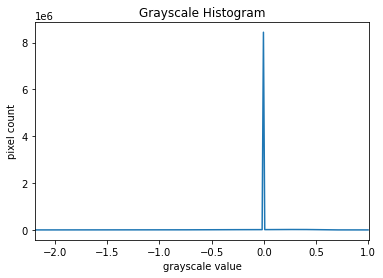

(186, 230, 230)


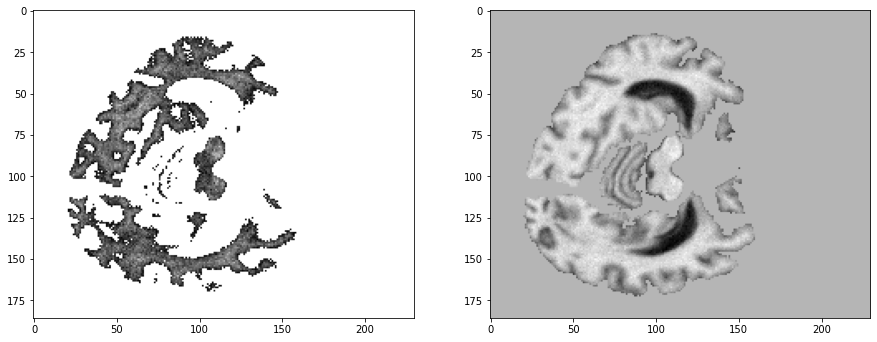

In [57]:
pixel_min, pixel_max = brain.min().item(), brain.max().item()
print(pixel_min, pixel_max)
histogram, bin_edges = np.histogram(brain, bins=256, range=(pixel_min, pixel_max))
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.xlim([pixel_min, pixel_max])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

new_img = np.where(brain < 0.001, 1, brain)
print(new_img.shape)
plt.figure("check", (15, 10))
plt.title("image")
plt.subplot(1, 2, 1)
plt.imshow(new_img[:, :, H], cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(brain[:, :, H], cmap="gray")

In [58]:
new_img

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1.

---------------------
# Test transform

테스트 목록:
* label 클래스 정리 transform
  * ClassesToIndicesd - 아닌듯 하다.
  * MapLabelValue : 이거다. (https://docs.monai.io/en/stable/transforms.html#monai.transforms.MapLabelValue)
* merge 4D(multi modality)

### try1. label encoding transform
* 현재 brain ROI model label은 배경(0)포함 총 102개의 클래스로 이루어져있다.
* 위 클래스들은 모두 ROI고유 번호로 매겨져있는데 이를 0부터 101 index로 바꾸려 한다.

In [7]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label", "brain", "mask"]),
        EnsureChannelFirstd(keys=["image", "label", "brain", "mask"]),
#         Spacingd(keys=["image", "label"], pixdim=(
#             1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label", "brain", "mask"], axcodes="RAS"),
#         Orientationd(keys=["image"], axcodes="LPS"),
#         ScaleIntensityRanged(
#             keys=["image"], a_min=-57, a_max=164,
#             b_min=0.0, b_max=1.0, clip=True,
#         ),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
#         EnsureTyped(keys=["image", "label"]),
#         ClassesToIndicesd(keys=["label"], num_classes=102)
    ]
)

test_ds = Dataset(data=val_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)
test_data = first(test_loader)
image, label = (test_data["image"], test_data["label"])
brain, mask = (test_data["brain"], test_data["mask"])
image.shape, label.shape, brain.shape, mask.shape

(torch.Size([1, 1, 186, 230, 230]),
 torch.Size([1, 1, 186, 230, 230]),
 torch.Size([1, 1, 186, 230, 230]),
 torch.Size([1, 1, 186, 230, 230]))

In [9]:
# 0은 배경이고 나머지 101개의 ROI가 있음.
import numpy as np
len(np.unique(label)), np.unique(label)

(102,
 array([0.000e+00, 2.000e+00, 4.000e+00, 5.000e+00, 7.000e+00, 8.000e+00,
        1.000e+01, 1.100e+01, 1.200e+01, 1.300e+01, 1.400e+01, 1.500e+01,
        1.600e+01, 1.700e+01, 1.800e+01, 2.400e+01, 2.600e+01, 2.800e+01,
        3.100e+01, 4.100e+01, 4.300e+01, 4.400e+01, 4.600e+01, 4.700e+01,
        4.900e+01, 5.000e+01, 5.100e+01, 5.200e+01, 5.300e+01, 5.400e+01,
        5.800e+01, 6.000e+01, 6.300e+01, 7.700e+01, 8.500e+01, 2.510e+02,
        2.520e+02, 2.530e+02, 2.540e+02, 2.550e+02, 1.002e+03, 1.003e+03,
        1.005e+03, 1.006e+03, 1.007e+03, 1.008e+03, 1.009e+03, 1.010e+03,
        1.011e+03, 1.012e+03, 1.013e+03, 1.014e+03, 1.015e+03, 1.016e+03,
        1.017e+03, 1.018e+03, 1.019e+03, 1.020e+03, 1.021e+03, 1.022e+03,
        1.023e+03, 1.024e+03, 1.025e+03, 1.026e+03, 1.027e+03, 1.028e+03,
        1.029e+03, 1.030e+03, 1.031e+03, 1.034e+03, 1.035e+03, 2.002e+03,
        2.003e+03, 2.005e+03, 2.006e+03, 2.007e+03, 2.008e+03, 2.009e+03,
        2.010e+03, 2.011e+03, 2.

In [10]:
label_classes = np.unique(label)
label_classes = label_classes.astype(int)
target_label_classes = np.array([each for each in range(len(label_classes))])
label_classes, target_label_classes

(array([   0,    2,    4,    5,    7,    8,   10,   11,   12,   13,   14,
          15,   16,   17,   18,   24,   26,   28,   31,   41,   43,   44,
          46,   47,   49,   50,   51,   52,   53,   54,   58,   60,   63,
          77,   85,  251,  252,  253,  254,  255, 1002, 1003, 1005, 1006,
        1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017,
        1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028,
        1029, 1030, 1031, 1034, 1035, 2002, 2003, 2005, 2006, 2007, 2008,
        2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
        2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
        2031, 2034, 2035]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  

In [11]:
aa = MapLabelValued(keys=["label"], orig_labels=label_classes, target_labels=target_label_classes)
result = aa(test_data)
result

{'image': tensor([[[[[-3.2265, -3.3943, -3.3267,  ..., -3.3379, -3.3266, -3.4207],
            [-3.3038, -3.3603, -3.3724,  ..., -3.4143, -3.5856, -3.3390],
            [-3.4326, -3.4444, -3.4597,  ..., -3.4657, -3.3709, -3.3641],
            ...,
            [-3.4239, -3.2843, -3.3561,  ..., -3.3421, -3.4019, -3.4754],
            [-3.5091, -3.4165, -3.5929,  ..., -3.3418, -3.3906, -3.4466],
            [-3.3271, -3.4534, -3.2895,  ..., -3.3730, -3.4524, -3.5109]],
 
           [[-3.1856, -3.4835, -3.4061,  ..., -3.4152, -3.4349, -3.4703],
            [-3.5033, -3.5127, -3.2953,  ..., -3.5435, -3.3767, -3.4697],
            [-3.3734, -3.2180, -3.4395,  ..., -3.3954, -3.2851, -3.5772],
            ...,
            [-3.5536, -3.3700, -3.4337,  ..., -3.4719, -3.4429, -3.3109],
            [-3.2932, -3.4717, -3.2857,  ..., -3.3661, -3.3361, -3.4872],
            [-3.5330, -3.2292, -3.3968,  ..., -3.4084, -3.3743, -3.4738]],
 
           [[-3.3326, -3.2843, -3.4502,  ..., -3.3440, -3.5798,

In [12]:
np.unique(result['label'])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101.], dtype=float32)

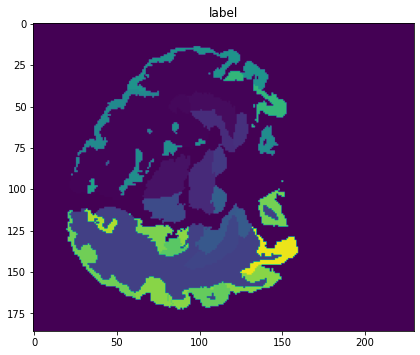

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101.]


In [15]:
H=100

label = result["label"][0][0]
plt.figure("check", (15, 10))
plt.subplot(1, 2, 1)
plt.title("label")
plt.imshow(label[:, :, H])
plt.show()

print(np.unique(label))

In [16]:
label

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [78]:
np.where(label == 2035)

(array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([118, 118, 118, ..., 142, 142, 142]),
 array([142, 143, 143, ..., 113, 114, 114]),
 array([107, 104, 105, ..., 115, 113, 114]))

In [84]:
# test_id = 2035
test_id = 14
target_idx = [ np.where(label == test_id)[i][0] for i in range(5) ]
label[target_idx[0], target_idx[1], target_idx[2], target_idx[3], target_idx[4]]

tensor(14.)

In [85]:
result['label'][target_idx[0], target_idx[1], target_idx[2], target_idx[3], target_idx[4]]

tensor(10.)

테스트 완료. 'MapLabelValue'로 알맞게 맵핑이 되는걸 확인하였다. 이젠 완전한 trasform을 확인할 차례

In [86]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label", "brain", "mask"]),
        EnsureChannelFirstd(keys=["image", "label", "brain", "mask"]),
        Orientationd(keys=["image", "label", "brain", "mask"], axcodes="RAS"),
        MapLabelValued(keys=["label"], orig_labels=label_classes, target_labels=target_label_classes)
    ]
)
test_ds = Dataset(data=val_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)
test_data = first(test_loader)
image, label = (test_data["image"], test_data["label"])
brain, mask = (test_data["brain"], test_data["mask"])
image.shape, label.shape, brain.shape, mask.shape

(torch.Size([1, 1, 186, 230, 230]),
 torch.Size([1, 1, 186, 230, 230]),
 torch.Size([1, 1, 186, 230, 230]),
 torch.Size([1, 1, 186, 230, 230]))

In [88]:
np.unique(label)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101.], dtype=float32)

In [87]:
label[target_idx[0], target_idx[1], target_idx[2], target_idx[3], target_idx[4]]

tensor(10.)

테스트 완료. 이젠 원본코드에 쓸 리스트를 만들자.

In [90]:
orig_label_classes, target_label_classes = (
    np.array([   0,    2,    4,    5,    7,    8,   10,   11,   12,   13,   14,
          15,   16,   17,   18,   24,   26,   28,   31,   41,   43,   44,
          46,   47,   49,   50,   51,   52,   53,   54,   58,   60,   63,
          77,   85,  251,  252,  253,  254,  255, 1002, 1003, 1005, 1006,
        1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017,
        1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028,
        1029, 1030, 1031, 1034, 1035, 2002, 2003, 2005, 2006, 2007, 2008,
        2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
        2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
        2031, 2034, 2035]),
    np.array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101]))

**완료**

----

### try2. multi modal transform
* Zag의 insight에 따르면 brain ROI model label 학습시 brain + mask -> label로 학습했을 때 더 좋을 것이라고 함 
* csf(ventricl)을 잡아야하는데 mask를 사용하면 좀더 확실히 찾을 수 있다고 함
* https://github.com/Project-MONAI/MONAI/issues/765
* https://www.kaggle.com/mikecho/rsna-miccai-monai-multimodal-2d-cnn-training
* https://github.com/Project-MONAI/tutorials/tree/master/multimodal
* https://github.com/Project-MONAI/tutorials/blob/master/multimodal/openi_multilabel_classification_transchex/transchex_openi_multilabel_classification.ipynb
* https://github.com/NifTK/NiftyNet

In [92]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label", "brain", "mask"]),
        EnsureChannelFirstd(keys=["image", "label", "brain", "mask"]),
#         Spacingd(keys=["image", "label"], pixdim=(
#             1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label", "brain", "mask"], axcodes="RAS"),
#         Orientationd(keys=["image"], axcodes="LPS"),
#         ScaleIntensityRanged(
#             keys=["image"], a_min=-57, a_max=164,
#             b_min=0.0, b_max=1.0, clip=True,
#         ),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
#         EnsureTyped(keys=["image", "label"]),
#         ClassesToIndicesd(keys=["label"], num_classes=102)
    ]
)

test_ds = Dataset(data=val_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)
test_data = first(test_loader)
image, label = (test_data["image"], test_data["label"])
brain, mask = (test_data["brain"], test_data["mask"])
image.shape, label.shape, brain.shape, mask.shape

(torch.Size([1, 1, 186, 230, 230]),
 torch.Size([1, 1, 186, 230, 230]),
 torch.Size([1, 1, 186, 230, 230]),
 torch.Size([1, 1, 186, 230, 230]))

In [106]:
# mask는 0과 1로만 구성되어있음
np.unique(mask)

array([0., 1.], dtype=float32)

In [102]:
aa = ConcatItemsd(keys=["brain", "mask"], name="new")
result = aa(test_ds[0])
result

{'image': array([[[[-3.2265213, -3.3942654, -3.3266907, ..., -3.3379107,
           -3.3265665, -3.4207268],
          [-3.3037858, -3.3602679, -3.3724377, ..., -3.4142997,
           -3.5856097, -3.3389506],
          [-3.4325821, -3.4443884, -3.4597185, ..., -3.465743 ,
           -3.3708854, -3.364101 ],
          ...,
          [-3.4239225, -3.2843277, -3.356101 , ..., -3.342081 ,
           -3.4019272, -3.4754078],
          [-3.5091348, -3.4165106, -3.5929017, ..., -3.341833 ,
           -3.3905554, -3.4465559],
          [-3.3270984, -3.4534087, -3.2895133, ..., -3.3730087,
           -3.452391 , -3.510867 ]],
 
         [[-3.18563  , -3.4835486, -3.4060676, ..., -3.4152384,
           -3.4349394, -3.4702659],
          [-3.503338 , -3.512672 , -3.2952774, ..., -3.543454 ,
           -3.3767247, -3.4697073],
          [-3.3734114, -3.218006 , -3.4395072, ..., -3.3954046,
           -3.2850993, -3.5772426],
          ...,
          [-3.553567 , -3.37002  , -3.433665 , ..., -3.471

In [103]:
result['new'].shape

(2, 186, 230, 230)

In [107]:
aa = ConcatItemsd(keys=["brain", "mask"], name="brain")
result = aa(test_ds[0])
result

{'image': array([[[[-3.2265213, -3.3942654, -3.3266907, ..., -3.3379107,
           -3.3265665, -3.4207268],
          [-3.3037858, -3.3602679, -3.3724377, ..., -3.4142997,
           -3.5856097, -3.3389506],
          [-3.4325821, -3.4443884, -3.4597185, ..., -3.465743 ,
           -3.3708854, -3.364101 ],
          ...,
          [-3.4239225, -3.2843277, -3.356101 , ..., -3.342081 ,
           -3.4019272, -3.4754078],
          [-3.5091348, -3.4165106, -3.5929017, ..., -3.341833 ,
           -3.3905554, -3.4465559],
          [-3.3270984, -3.4534087, -3.2895133, ..., -3.3730087,
           -3.452391 , -3.510867 ]],
 
         [[-3.18563  , -3.4835486, -3.4060676, ..., -3.4152384,
           -3.4349394, -3.4702659],
          [-3.503338 , -3.512672 , -3.2952774, ..., -3.543454 ,
           -3.3767247, -3.4697073],
          [-3.3734114, -3.218006 , -3.4395072, ..., -3.3954046,
           -3.2850993, -3.5772426],
          ...,
          [-3.553567 , -3.37002  , -3.433665 , ..., -3.471

In [108]:
# 덮어 쓸수도 있음
result['brain'].shape

(2, 186, 230, 230)

In [112]:
aa = ConcatItemsd(keys=["brain", "mask"], name="brain", dim=1)
result = aa(test_data)
result

{'image': tensor([[[[[-3.2265, -3.3943, -3.3267,  ..., -3.3379, -3.3266, -3.4207],
            [-3.3038, -3.3603, -3.3724,  ..., -3.4143, -3.5856, -3.3390],
            [-3.4326, -3.4444, -3.4597,  ..., -3.4657, -3.3709, -3.3641],
            ...,
            [-3.4239, -3.2843, -3.3561,  ..., -3.3421, -3.4019, -3.4754],
            [-3.5091, -3.4165, -3.5929,  ..., -3.3418, -3.3906, -3.4466],
            [-3.3271, -3.4534, -3.2895,  ..., -3.3730, -3.4524, -3.5109]],
 
           [[-3.1856, -3.4835, -3.4061,  ..., -3.4152, -3.4349, -3.4703],
            [-3.5033, -3.5127, -3.2953,  ..., -3.5435, -3.3767, -3.4697],
            [-3.3734, -3.2180, -3.4395,  ..., -3.3954, -3.2851, -3.5772],
            ...,
            [-3.5536, -3.3700, -3.4337,  ..., -3.4719, -3.4429, -3.3109],
            [-3.2932, -3.4717, -3.2857,  ..., -3.3661, -3.3361, -3.4872],
            [-3.5330, -3.2292, -3.3968,  ..., -3.4084, -3.3743, -3.4738]],
 
           [[-3.3326, -3.2843, -3.4502,  ..., -3.3440, -3.5798,

In [113]:
# 덮어 쓸수도 있음
result['brain'].shape

torch.Size([1, 2, 186, 230, 230])

테스트 완료. default는 0이나 내가 지정한 dim으로 combine가능. 이제 transform 완성형태 작성

In [115]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label", "brain", "mask"]),
        EnsureChannelFirstd(keys=["image", "label", "brain", "mask"]),
        Orientationd(keys=["image", "label", "brain", "mask"], axcodes="RAS"),
        MapLabelValued(keys=["label"], orig_labels=label_classes, target_labels=target_label_classes),
        ConcatItemsd(keys=["brain", "mask"], name="brain")
    ]
)
test_ds = Dataset(data=val_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)
test_data = first(test_loader)
image, label = (test_data["image"], test_data["label"])
brain, mask = (test_data["brain"], test_data["mask"])
image.shape, label.shape, brain.shape, mask.shape

(torch.Size([1, 1, 186, 230, 230]),
 torch.Size([1, 1, 186, 230, 230]),
 torch.Size([1, 2, 186, 230, 230]),
 torch.Size([1, 1, 186, 230, 230]))

**완성**

----

#### -0 tensor를 변경하자
Lambdad 적용 테스트

In [66]:
basic_transforms = Compose(
    [
        LoadImaged(keys=["image", "label", "brain", "mask"]),
        EnsureChannelFirstd(keys=["image", "label", "brain", "mask"]),
        Orientationd(keys=["image", "label", "brain", "mask"], axcodes="RAS"),
    ]
)
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label", "brain", "mask"]),
        EnsureChannelFirstd(keys=["image", "label", "brain", "mask"]),
        Orientationd(keys=["image", "label", "brain", "mask"], axcodes="RAS"),
        Lambdad(keys='brain', func=lambda x: np.where(x==-0, 0, x))
    ]
)
ori_ds = Dataset(data=val_files, transform=basic_transforms)
ori_loader = DataLoader(ori_ds, batch_size=1)
ori_data = first(ori_loader)
ori_image, ori_label = (ori_data["image"], ori_data["label"])
ori_brain, ori_mask = (ori_data["brain"], ori_data["mask"])


test_ds = Dataset(data=val_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)
test_data = first(test_loader)
image, label = (test_data["image"], test_data["label"])
brain, mask = (test_data["brain"], test_data["mask"])
image.shape, label.shape, brain.shape, mask.shape

(torch.Size([1, 1, 186, 230, 230]),
 torch.Size([1, 1, 186, 230, 230]),
 torch.Size([1, 1, 186, 230, 230]),
 torch.Size([1, 1, 186, 230, 230]))

In [67]:
ori_brain

tensor([[[[[-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           ...,
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.]],

          [[-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           ...,
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.]],

          [[-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           ...,
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.]],

          ...,

          [[-0., -0., -0.,  ..., -0., -0., -0.],

In [68]:
brain

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           

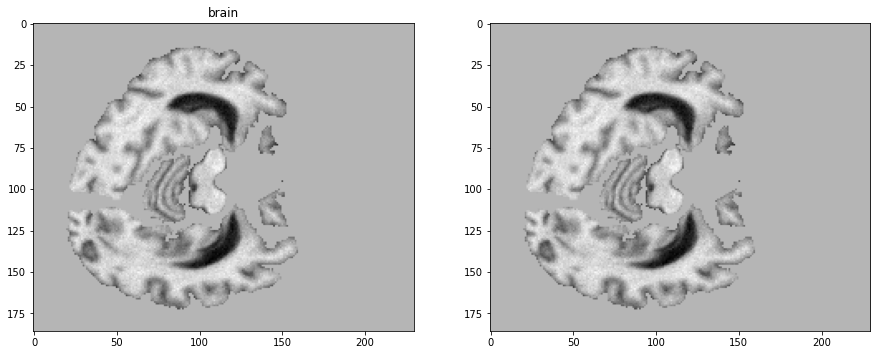

In [70]:
plt.figure("check", (15, 10))
plt.title("ori brain")
plt.subplot(1, 2, 1)
plt.imshow(ori_brain[0,0, :, :, H], cmap="gray")
plt.title("brain")
plt.subplot(1, 2, 2)
plt.imshow(brain[0,0, :, :, H], cmap="gray")

#### Intensity 를 정규화 하자.
ScaleIntensityd 테스트

In [73]:
basic_transforms = Compose(
    [
        LoadImaged(keys=["image", "label", "brain", "mask"]),
        EnsureChannelFirstd(keys=["image", "label", "brain", "mask"]),
        Orientationd(keys=["image", "label", "brain", "mask"], axcodes="RAS"),
    ]
)
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label", "brain", "mask"]),
        EnsureChannelFirstd(keys=["image", "label", "brain", "mask"]),
        Orientationd(keys=["image", "label", "brain", "mask"], axcodes="RAS"),
#         Lambdad(keys='brain', func=lambda x: np.where(x==-0, 0, x))
        ScaleIntensityd(keys=["brain"], minv=0.0, maxv=1.0)
    ]
)
ori_ds = Dataset(data=val_files, transform=basic_transforms)
ori_loader = DataLoader(ori_ds, batch_size=1)
ori_data = first(ori_loader)
ori_image, ori_label = (ori_data["image"], ori_data["label"])
ori_brain, ori_mask = (ori_data["brain"], ori_data["mask"])


test_ds = Dataset(data=val_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)
test_data = first(test_loader)
image, label = (test_data["image"], test_data["label"])
brain, mask = (test_data["brain"], test_data["mask"])
image.shape, label.shape, brain.shape, mask.shape

(torch.Size([1, 1, 186, 230, 230]),
 torch.Size([1, 1, 186, 230, 230]),
 torch.Size([1, 1, 186, 230, 230]),
 torch.Size([1, 1, 186, 230, 230]))

In [76]:
ori_brain

tensor([[[[[-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           ...,
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.]],

          [[-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           ...,
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.]],

          [[-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           ...,
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.],
           [-0., -0., -0.,  ..., -0., -0., -0.]],

          ...,

          [[-0., -0., -0.,  ..., -0., -0., -0.],

In [75]:
brain

tensor([[[[[0.6846, 0.6846, 0.6846,  ..., 0.6846, 0.6846, 0.6846],
           [0.6846, 0.6846, 0.6846,  ..., 0.6846, 0.6846, 0.6846],
           [0.6846, 0.6846, 0.6846,  ..., 0.6846, 0.6846, 0.6846],
           ...,
           [0.6846, 0.6846, 0.6846,  ..., 0.6846, 0.6846, 0.6846],
           [0.6846, 0.6846, 0.6846,  ..., 0.6846, 0.6846, 0.6846],
           [0.6846, 0.6846, 0.6846,  ..., 0.6846, 0.6846, 0.6846]],

          [[0.6846, 0.6846, 0.6846,  ..., 0.6846, 0.6846, 0.6846],
           [0.6846, 0.6846, 0.6846,  ..., 0.6846, 0.6846, 0.6846],
           [0.6846, 0.6846, 0.6846,  ..., 0.6846, 0.6846, 0.6846],
           ...,
           [0.6846, 0.6846, 0.6846,  ..., 0.6846, 0.6846, 0.6846],
           [0.6846, 0.6846, 0.6846,  ..., 0.6846, 0.6846, 0.6846],
           [0.6846, 0.6846, 0.6846,  ..., 0.6846, 0.6846, 0.6846]],

          [[0.6846, 0.6846, 0.6846,  ..., 0.6846, 0.6846, 0.6846],
           [0.6846, 0.6846, 0.6846,  ..., 0.6846, 0.6846, 0.6846],
           [0.6846, 0.6846

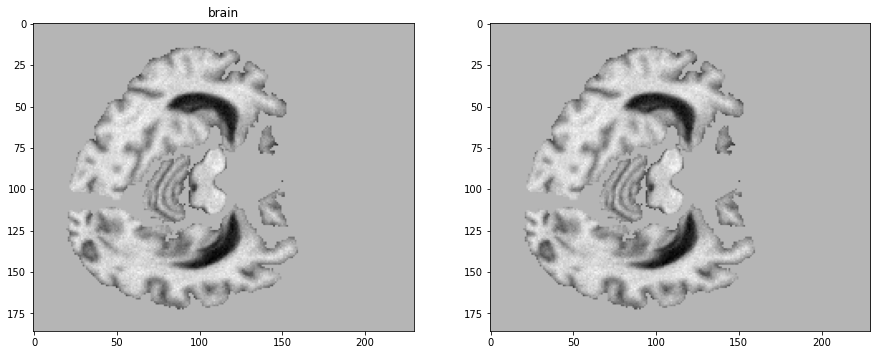

In [77]:
plt.figure("check", (15, 10))
plt.title("ori brain")
plt.subplot(1, 2, 1)
plt.imshow(ori_brain[0,0, :, :, H], cmap="gray")
plt.title("brain")
plt.subplot(1, 2, 2)
plt.imshow(brain[0,0, :, :, H], cmap="gray")

0.0 1.0


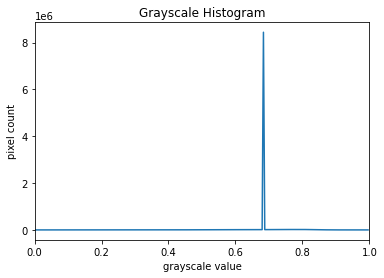

In [78]:
pixel_min, pixel_max = brain.min().item(), brain.max().item()
print(pixel_min, pixel_max)
histogram, bin_edges = np.histogram(brain, bins=256, range=(pixel_min, pixel_max))
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.xlim([pixel_min, pixel_max])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()